# Low-dimensional systems
**by <span style="color:darkgreen">Andris Gulans</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Andris Gulans</span> & <span style="color:darkgreen">Mara Voiculescu</span>)</font>
<hr style="border:2px solid #DDD"></hr>

**<span style="color:firebrick">Purpose</span>**:  This tutorial gives an introduction into running ground state calculations for low-dimensional and sparse systems efficiently. Assuming the bottleneck of the calculation is the diagonalization, the computational effort can be significantly reduced by applying the Davidson eigensolver.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**
    
[0. Before Starting](#0)
    
[1. Theoretical Background](#1)  
    
[2. Introducing alpha-graphyne](#2)

[3. Using the Davidson eigensolver](#3)

[4. Plotting the band dispersion](#4)

[5. Can you afford higher rgkmax?](#5)

    
</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

As a first step, you may create a running directory for the notebook.

In [1]:
%%bash
mkdir -p run_graphyne

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Theoretical Background</span>

Low-dimensional systems attract particular interest in modern materials research, and **`exciting`** can be used for studying them. The LAPW basis assumes periodicity in three dimensions, and specifying geometry of such systems involves large vacuum regions to prevent interactions between periodic images. As a result, one obtains large unit cells even for several atoms, and it leads to large basis sets and heavy calculations. 

Suppose the unit cell of the studied system contains $N_\mathrm{at}$ atoms, and the basis consists of $N_\mathrm{LAPW}$ LAPWs. In the limit of large $N_\mathrm{LAPW}$, the most laborious step of a ground-state DFT calculation employing a (semi)local exchange-correlation functional is a Hamiltonian construction and diagonalization. Standard LAPW implementations use direct matrix diagonalization algorithms as implemented in LAPACK and other linear algebra libraries. With the matrix size $N_\mathrm{LAPW} \times N_\mathrm{LAPW}$, these algorithms require $O(N_\mathrm{LAPW}^3)$ floating-point operations (FLOPs). 

Considering low-dimensional systems, we notice that the required number of bands (all occupied and a few unoccupied) is small compared to $N_\mathrm{LAPW}$, and it is typically well under 1%. This is a scenario where iterative algorithms are expected to have an advantage over the direct ones. This tutorial shows how to apply the Davidson eigensolver implemented in **`exciting`**. The method was orinally introduced by E.R. Davidson in Journal of Computational Physics 17, 87 (1975), and applied in an LAPW calculation for the first time by D. Singh in Physical Review B 40, 5428 (1989). The implementation in **`exciting`** extends this approach to (L)APW+lo taking into account that the basis becomes essentially linearly dependent at large **rgkmax** values. The implementation is briefly described by A. Gulans, A. Kozhevnikov, C. Draxl in Phys. Rev. B 97, 161105(R) (2018). 

The iterative eigensolver implemented in **`exciting`** constructs a subspace of trial wavefunctions, and it crucially depends on the ability to apply the Hamiltonian on the trial wavefunction, but it does not require that the Hamiltonian matrix is explicitly constructed. **`exciting`** supports both options: (i) the Hamiltonian matrix is explicitly constructed (occupies more memory, but it is more flexible in terms what kind of calculations are supported), (ii) the Hamiltonian matrix is never built (advantageous in many cases as it uses less memory and is typically faster).


<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Introducing $\alpha$-graphyne</span>



$\alpha$-graphene is a two-dimensional carbon allotrope consisting of $sp$- and $sp^2$-hybridized atoms. In this tutorial, we discuss applying the iterative eigensolver for calculating the band dispersion of this material. We start with preparing an input for a standard calculation that employs the default option, a direct eigensolver from LAPACK. 

<span class="GRAPHYNE"></span>
```xml
<input>

  <title>Graphyne</title>
    
  <structure speciespath="." >
    <crystal scale="1.0">
      <basevect>13.163831236 0.00000000000000 0.00000000000000</basevect>
      <basevect>-6.581915618 11.400212262 0.00000000000000</basevect>
      <basevect>0.00000000000000 0.00000000000000 20.0</basevect>
    </crystal>
    <species chemicalSymbol="C" speciesfile="C.xml" rmt="1.15">
      <atom coord="0.0000000000 0.0000000000 0.0000000000"/>
      <atom coord="0.6666666667 0.3333333333 0.0000000000"/>
      <atom coord="0.2313939997 0.1156969998 0.0000000000"/>
      <atom coord="0.4352726670 0.2176363335 0.0000000000"/>
      <atom coord="0.7823636665 0.2176363335 0.0000000000"/>
      <atom coord="0.8843030002 0.1156969998 0.0000000000"/>
      <atom coord="0.7823636665 0.5647273330 0.0000000000"/>
      <atom coord="0.8843030002 0.7686060003 0.0000000000"/>
    </species>
  </structure>

  <groundstate 
    ngridk="4 4 1"
    rgkmax="4"
    gmaxvr="20" 
    maxscl="30"
    radialgridtype="cubic-2"
    xctype="LDA_PW"
>
 <solver
    type='Lapack'
    />
  </groundstate>

</input>
```

As explained above, we introduce a large vacuum gap (20 bohr) between the graphyne layers to eliminate interactions between the periodic images. You can explore the structure by visualizing the structure as shown below. But, before you do it, please, notice that we chose a small value of the <code><span style="color:mediumblue">rgkmax</span></code> parameter just for getting started, and, in principle, it should be converged with respect to the quantity of interest. Also, the attribute type in the element solver is specified. Its default value is <code><span style="color:firebrick">Lapack</span></code>, and therefore providing it is not mandatory at this point. 

In [2]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("Low_dimensional_systems", "GRAPHYNE")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_graphyne/input.lapack.xml'), "w") as fid:
    fid.write(input_str)

In [3]:
# Extract species file content from this notebook:
species_str = get_input_xml_from_notebook("Low_dimensional_systems", "CARBON_SPECIES")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_graphyne/C.xml'), "w") as fid:
    fid.write(species_str)

In [4]:
%%bash
cd run_graphyne
xcrysden --exciting input.lapack.xml >/dev/null 2>&1 &
cd ..

Now we provide our favourite species definition for carbon. Note that the LAPW energy parameter for the radial functions with $l=0$ is set to correspond to the $2s$ band energy rather than $1s$. It is irrelevant when you use the direct eigensolvers, but it is crucially important for using the Davidson's method.

<span class="CARBON_SPECIES"></span>
```xml
<spdb xsi:noNamespaceSchemaLocation="../../xml/species.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
  <sp chemicalSymbol="C" name="carbon" z="-6.00000" mass="21894.16673">
    <muffinTin rmin="0.100000E-05" radius="1.4500" rinf="21.1565" radialmeshPoints="300"/>
    <atomicState n="1" l="0" kappa="1" occ="2.00000" core="false"/>
    <atomicState n="2" l="0" kappa="1" occ="2.00000" core="false"/>
    <atomicState n="2" l="1" kappa="1" occ="1.00000" core="false"/>
    <atomicState n="2" l="1" kappa="2" occ="1.00000" core="false"/>
    <basis>
      <default type="lapw" trialEnergy="0.15" searchE="false"/>
      <custom l="0" type="lapw" trialEnergy="-0.70" searchE="false"/>
      <lo l="0">
        <wf matchingOrder="0" trialEnergy="-0.70" searchE="false"/>
        <wf matchingOrder="1" trialEnergy="-0.70" searchE="false"/>
      </lo>
      <lo l="0">
        <wf matchingOrder="0" trialEnergy="-0.70" searchE="false"/>
        <wf matchingOrder="0" trialEnergy="-9.9" searchE="false"/>
      </lo>
      <lo l="0">
        <wf matchingOrder="0" trialEnergy="-9.9" searchE="false"/>
        <wf matchingOrder="1" trialEnergy="-9.9" searchE="false"/>
      </lo>
      <lo l="0">
        <wf matchingOrder="1" trialEnergy="-9.9" searchE="false"/>
        <wf matchingOrder="2" trialEnergy="-9.9" searchE="false"/>
      </lo>

      <custom l="1" type="lapw" trialEnergy="-0.20" searchE="false"/>
      <lo l="1">
        <wf matchingOrder="0" trialEnergy="-0.20" searchE="false"/>
        <wf matchingOrder="1" trialEnergy="-0.20" searchE="false"/>
      </lo>
      <lo l="1">
        <wf matchingOrder="1" trialEnergy="-0.20" searchE="false"/>
        <wf matchingOrder="2" trialEnergy="-0.20" searchE="false"/>
      </lo>

    </basis>
  </sp>
</spdb>
```

Now we save the inputs and run the calculation.

In [5]:
%%bash
pwd
cd run_graphyne
time exciting_smp input.lapack.xml
cat TOTENERGY.OUT
cd ..

/home/andris/exciting-neon/exciting/tools/excitingjupyter/excitingjupyter/02_ground_state
 ### Using specified input file: input.lapack.xml


   Elapsed time = 2m51s


    -313.089395891    
    -308.538813992    
    -305.443394867    
    -301.894734691    
    -301.829111721    
    -301.828487062    
    -301.823393599    
    -301.825246621    
    -301.825517241    
    -301.825445272    
    -301.825445077    
    -301.825445024    
    -301.825445033    



<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Using the Davidson eigensolver</span>

Constructing the Hamiltonian and overlap matrices and diagonalizing the Hamiltonian problem take a large portion of the total run time. We can speed up this calculation by using the Davidson eigensolver. This adjustment is simple, as you have to adjust the attribute <code><span style="color:mediumblue">type</span></code> in the element <code><span style="color:green">groundstate/solver</span></code> from <code><span style="color:firebrick">Lapack</span></code> to <code><span style="color:firebrick">Davidson</span></code>. We run the code again.


In [6]:
from excitingtools import ExcitingInputXML

new_input_xml = ExcitingInputXML.from_xml(os.path.join(os.getcwd(), 'run_graphyne/input.lapack.xml'))
new_input_xml.groundstate.solver.type = "Davidson"
with open(os.path.join(os.getcwd(), 'run_graphyne/input.iterative.xml'), "w") as fid:
 fid.write(new_input_xml.to_xml_str())
#print(new_input_xml.to_xml_str())

In [7]:
%%bash
cd run_graphyne
time exciting_smp input.iterative.xml
cat TOTENERGY.OUT
cd ..

 ### Using specified input file: input.iterative.xml


   Elapsed time = 1m16s


    -313.089395865    
    -308.538814001    
    -305.443394873    
    -301.894734708    
    -301.829111722    
    -301.828487069    
    -301.823393623    
    -301.825246587    
    -301.825517261    
    -301.825445262    
    -301.825445070    
    -301.825445057    
    -301.825445044    



Notice the reduction in the run time, while the total energy remains unchanged (within the convergence criteria) compared to the LAPACK calculation. 

In the next step, we explore what is the effect of constructing or not constructing the Hamiltonian matrix during the iterative diagonalization. This choice is defined in the attribute <code><span style="color:mediumblue">constructHS</span></code> in the element <code><span style="color:green">groundstate/solver</span></code>. The default value of the attribute is <code><span style="color:firebrick">true</span></code> meaning that the Hamiltonian is explicitly constructed. We will change it to <code><span style="color:firebrick">false</span></code> and rerun the calculation.

In [8]:
new_input_v2_xml = ExcitingInputXML.from_xml(os.path.join(os.getcwd(), 'run_graphyne/input.lapack.xml'))
new_input_v2_xml.groundstate.solver.type = "Davidson"
new_input_v2_xml.groundstate.solver.constructHS = "false"
with open(os.path.join(os.getcwd(), 'run_graphyne/input.iterative_v2.xml'), "w") as fid:
 fid.write(new_input_v2_xml.to_xml_str())

In [9]:
%%bash
cd run_graphyne
time exciting_smp input.iterative_v2.xml
cat TOTENERGY.OUT
cd ..

 ### Using specified input file: input.iterative_v2.xml


   Elapsed time = 0m59s


    -313.089395865    
    -308.538814001    
    -305.443394874    
    -301.894734711    
    -301.829111717    
    -301.828487068    
    -301.823393623    
    -301.825246587    
    -301.825517261    
    -301.825445262    
    -301.825445070    
    -301.825445057    
    -301.825445044    



We managed to reduce the run time even further, and this is the optimal option for this system. At fixed <code><span style="color:mediumblue">rgkmax</span></code>, the require number of FLOPs for the iterative solver is $O(N_\mathrm{at}N_\mathrm{LAPW}^2)$ and $O(N_\mathrm{at}^2 N_\mathrm{LAPW})$ when we construct or do not construct the Hamiltonian, respectively. If <code><span style="color:mediumblue">rgkmax</span></code> is varied while the volume of the unit cell and the number of atoms are fixed, estimating the computational effort is not as straightforward, but the iterative solver is more advantageous than the direct one for low-dimensional systems.

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Plotting the band dispersion</span>

The diagonalization is performed during the self-consistence cycle, but not exclusively. For example, plotting the band structure requires it too. Although the choice of the eigensolver is made in the groundstate/solver element, it applies to the properties calculations too. The input below plots the band dispersion.

<span class="GRAPHYNE_PROPERTIES"></span>
```xml
<input>

  <title>Graphyne</title>

  <structure speciespath="." >
    <crystal scale="1.0">
      <basevect>13.163831236 0.00000000000000 0.00000000000000</basevect>
      <basevect>-6.581915618 11.400212262 0.00000000000000</basevect>
      <basevect>0.00000000000000 0.00000000000000 20.0</basevect>
    </crystal>
    <species chemicalSymbol="C" speciesfile="C.xml" rmt="1.15">
      <atom coord="0.0000000000 0.0000000000 0.0000000000"/>
      <atom coord="0.6666666667 0.3333333333 0.0000000000"/>
      <atom coord="0.2313939997 0.1156969998 0.0000000000"/>
      <atom coord="0.4352726670 0.2176363335 0.0000000000"/>
      <atom coord="0.7823636665 0.2176363335 0.0000000000"/>
      <atom coord="0.8843030002 0.1156969998 0.0000000000"/>
      <atom coord="0.7823636665 0.5647273330 0.0000000000"/>
      <atom coord="0.8843030002 0.7686060003 0.0000000000"/>
    </species>
  </structure>

  <groundstate 
    ngridk="4 4 1"
    rgkmax="4"
    gmaxvr="20" 
    maxscl="30"
    radialgridtype="cubic-2"
    xctype="LDA_PW"
    do="skip"
    nempty="10"
>
 <solver
    type='Davidson'
    constructHS='false'
    />
  </groundstate>
  <properties>
      <bandstructure>
         <plot1d>
            <path steps="25">
               <point coord="0.0     0.0     0.0" label="Gamma"/>
               <point coord="0.0     0.5   0.0" label="M"/>
               <point coord="0.3333333333  0.3333333333 0" label="K"/>
               <point coord="0.0     0.0     0.0" label="Gamma"/>
            </path>
         </plot1d>
      </bandstructure>
  </properties>
</input>
```

In [10]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("Low_dimensional_systems", "GRAPHYNE_PROPERTIES")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_graphyne/input.xml'), "w") as fid:
    fid.write(input_str)

In [11]:
%%bash
cd run_graphyne
time exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml
 ### Using specified input file: input.xml

Info(bandstr):
 band structure plot written to BAND.OUT

 Fermi energy is at zero in plot

 Vertex location lines written to BANDLINES.OUT



   Elapsed time = 0m20s


In [12]:
%%bash
cd run_graphyne
python3 -m excitingscripts.plot.band_structure -e -10 5
cd ..

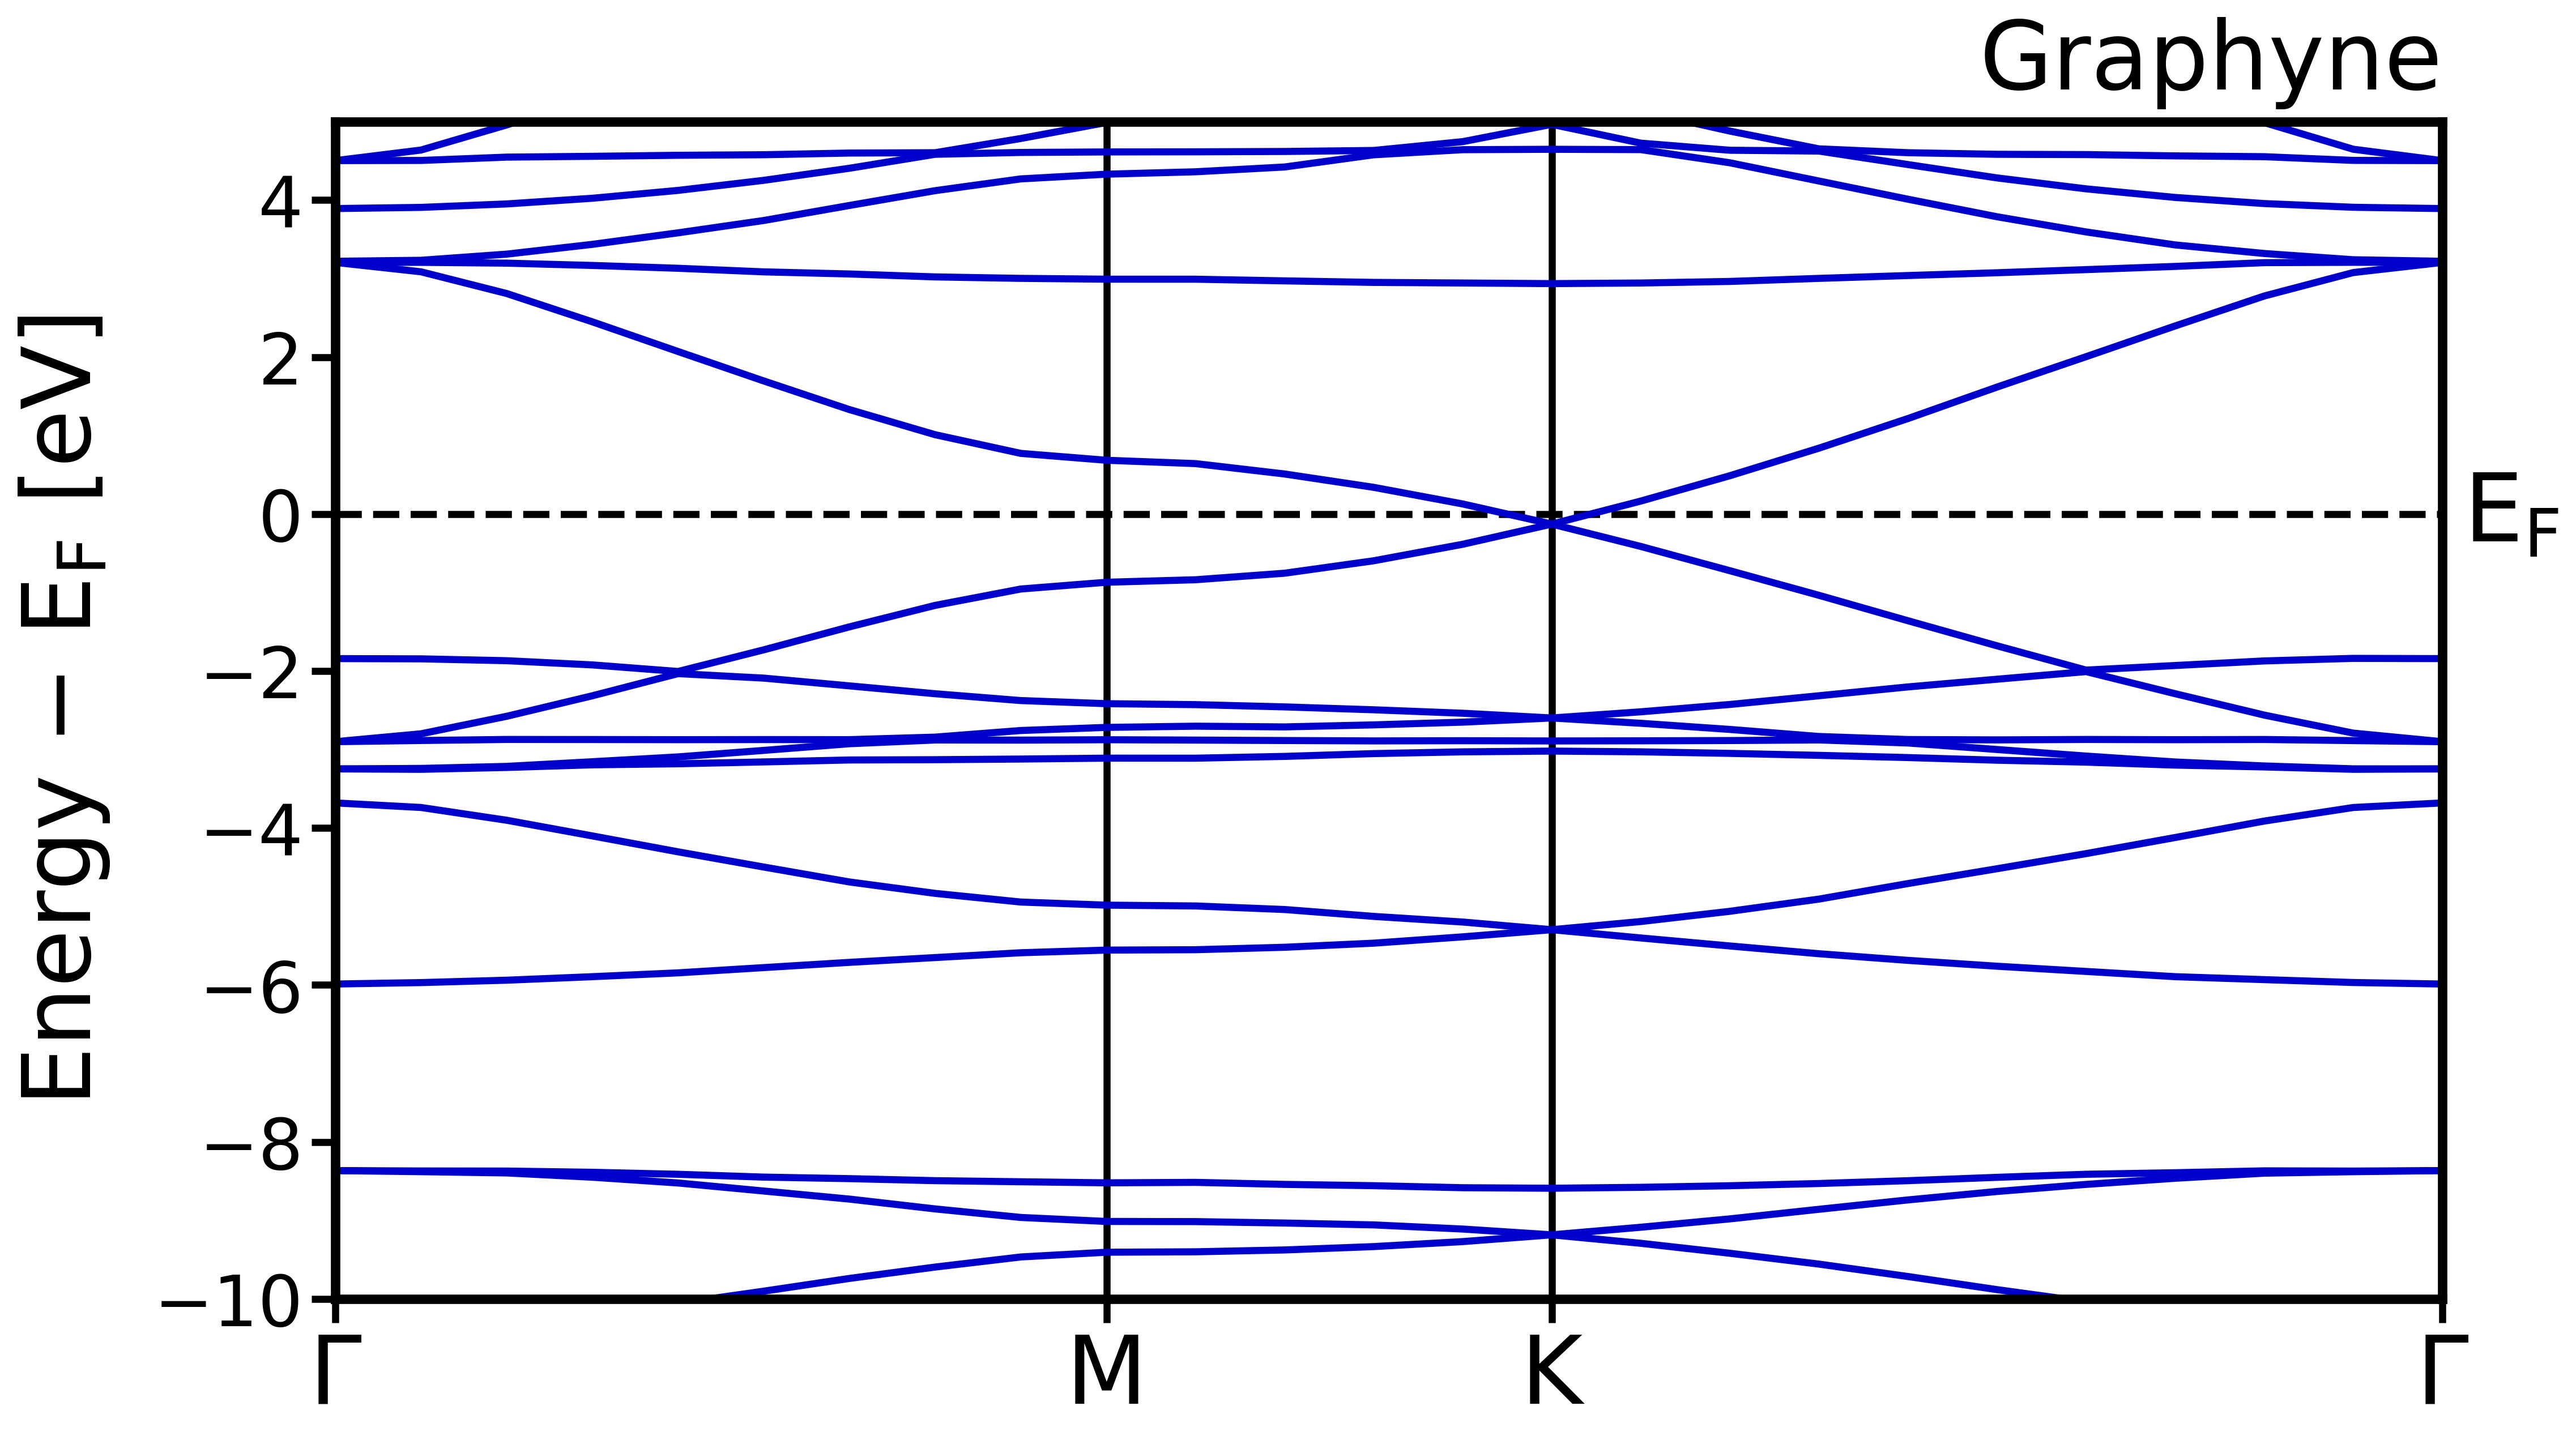

In [13]:
from IPython.display import Image
Image(filename="run_graphyne/PLOT.png")

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. Can you afford higher rgkmax?</span>

In the previous sections, we performed initial calculations with the parameter selection that allows us to get started quickly. A production calculation would require higher <code><span style="color:mediumblue">rgkmax</span></code> value and a finer $\mathbf{k}$-grid. In this tutorial, we limit ourselves to discussing <code><span style="color:mediumblue">rgkmax</span></code>. 
The choice of this parameter depends on the precision targets and the quantities of the interest, but typically the reasonable values are in the range 6--10 for carbon. Let us assume the most optimistic scenario where <code><span style="color:mediumblue">rgkmax</span></code>=6 is sufficient. How much more expensive our calculation will get in comparison with what we did in the previous sections? Here is "a back of the envelope" estimate. The number of the basis functions scales as $N_\mathrm{LAPW}\propto \mathrm{rgkmax}^3$, and $N_\mathrm{LAPW}$ increases $(\mathrm{rgkmax}^\mathrm{new}/\mathrm{rgkmax}^\mathrm{old})^3 \approx 3.4$ times. Direct eigensolvers from the LAPACK library require $O(N_\mathrm{LAPW}^3)$ FLOPs which translates into $3.4^3\approx 38$ times longer runtime spent on the diagonalization! 
How long would it take to run the calculation using the iterative eigensolver? Let us run and see!

In [14]:
new_input_rgkmax6_xml = ExcitingInputXML.from_xml(os.path.join(os.getcwd(), 'run_graphyne/input.lapack.xml'))
new_input_rgkmax6_xml.groundstate.rgkmax = "6"
new_input_rgkmax6_xml.groundstate.solver.type = "Davidson"
new_input_rgkmax6_xml.groundstate.solver.constructHS = "false"
with open(os.path.join(os.getcwd(), 'run_graphyne/input.rgkmax6.xml'), "w") as fid:
 fid.write(new_input_rgkmax6_xml.to_xml_str())

In [15]:
%%bash
cd run_graphyne
time exciting_smp input.rgkmax6.xml
cd ..

 ### Using specified input file: input.rgkmax6.xml


   Elapsed time = 3m0s
